In [43]:
import numpy as np
import pandas as pd
import sys
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import os
from sklearn.metrics import mean_squared_error

<AxesSubplot:>

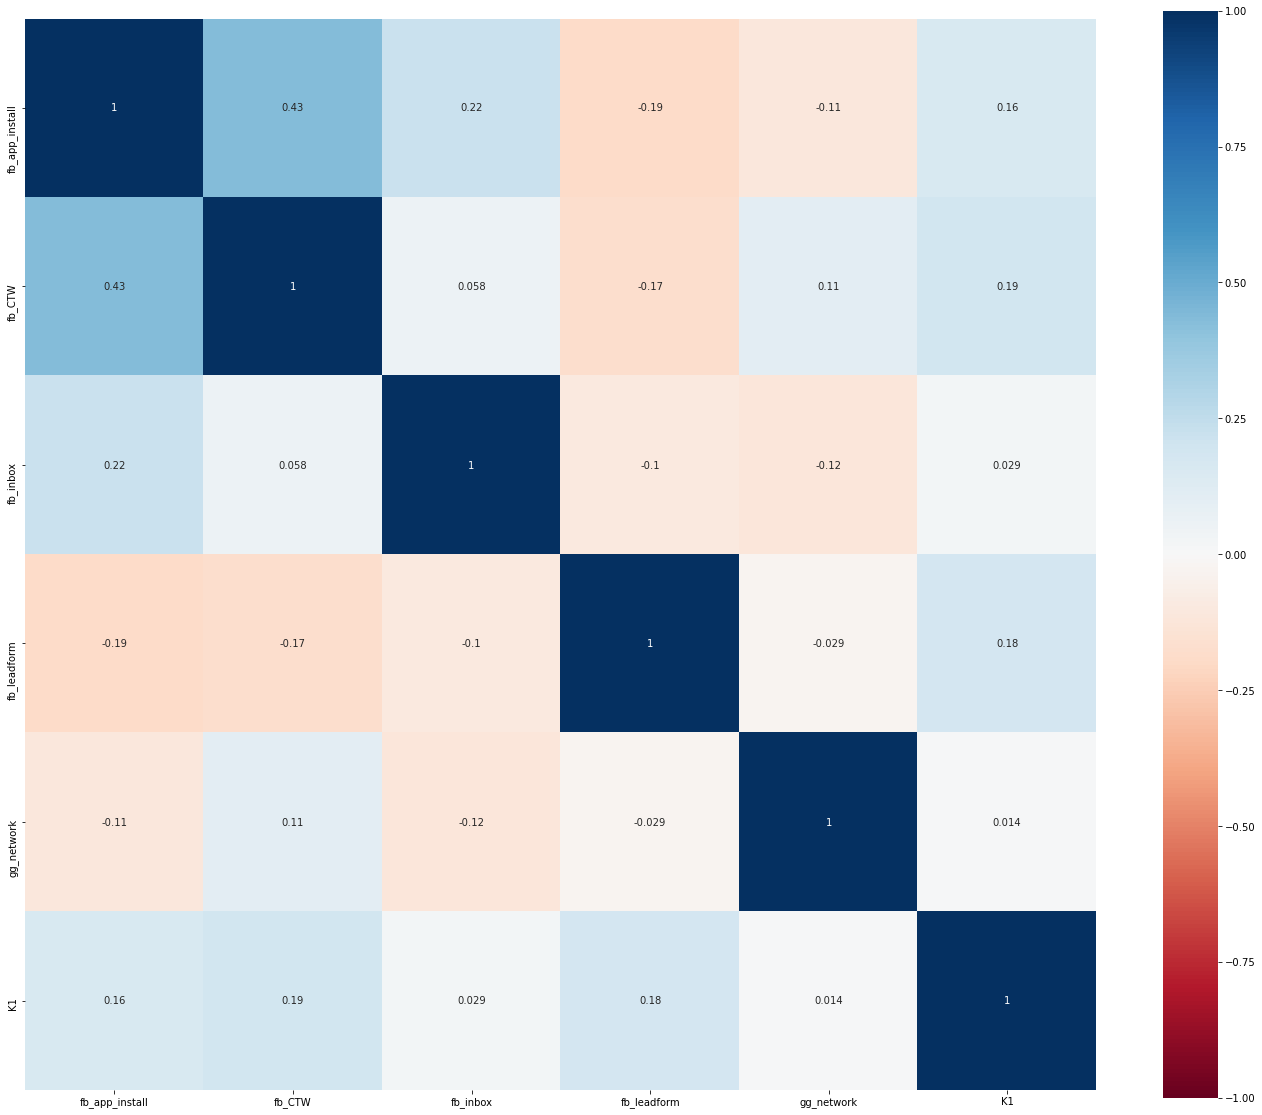

In [97]:
# Getting data
team1 = pd.read_csv('team6.csv')

# Marketing channel variables
fb_cols = [col for col in team1.columns if 'fb_' in col]
gg_cols = [col for col in team1.columns if 'gg_' in col]
ads_cols = fb_cols + gg_cols

# Impact varaibles
Impact = ['K1']

# Other control variables
hld_col =[col for col in team1.columns if 'hld_' in col]
# mac_col =[col for col in team1.columns if 'mac_' in col]
# var_col = hld_col + mac_col

plt.figure(figsize=(24,20))
sns.heatmap(team1[fb_cols+ gg_cols + ['K1']].corr(), square=True, annot=True, vmax=1, vmin=-1, cmap='RdBu')

In [45]:
team1

,Date,fb_app_install,fb_conversion,fb_CTW,fb_inbox,fb_leadform,gg_network,gg_search,gg_youtube,K1,hld_holiday,hld_wkn
0,2021-01-01,0,0,0,1191392,0,0,0,0,0,1,0
1,2021-01-02,0,0,0,1220635,0,0,0,0,1,0,1
2,2021-01-03,0,0,0,1002002,0,0,0,0,2,0,1
3,2021-01-04,0,0,0,730694,0,0,0,0,1,0,0
4,2021-01-05,0,0,0,641714,682246,0,0,0,10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
90,2021-04-01,696840,0,104669,731533,0,0,0,0,14,0,0
91,2021-04-02,687365,0,104515,741949,0,0,0,0,18,0,0
92,2021-04-03,675670,0,104180,786589,0,0,0,0,12,0,1
93,2021-04-04,668357,0,110151,729364,0,0,0,0,23,0,1


<Figure size 3600x3600 with 0 Axes>

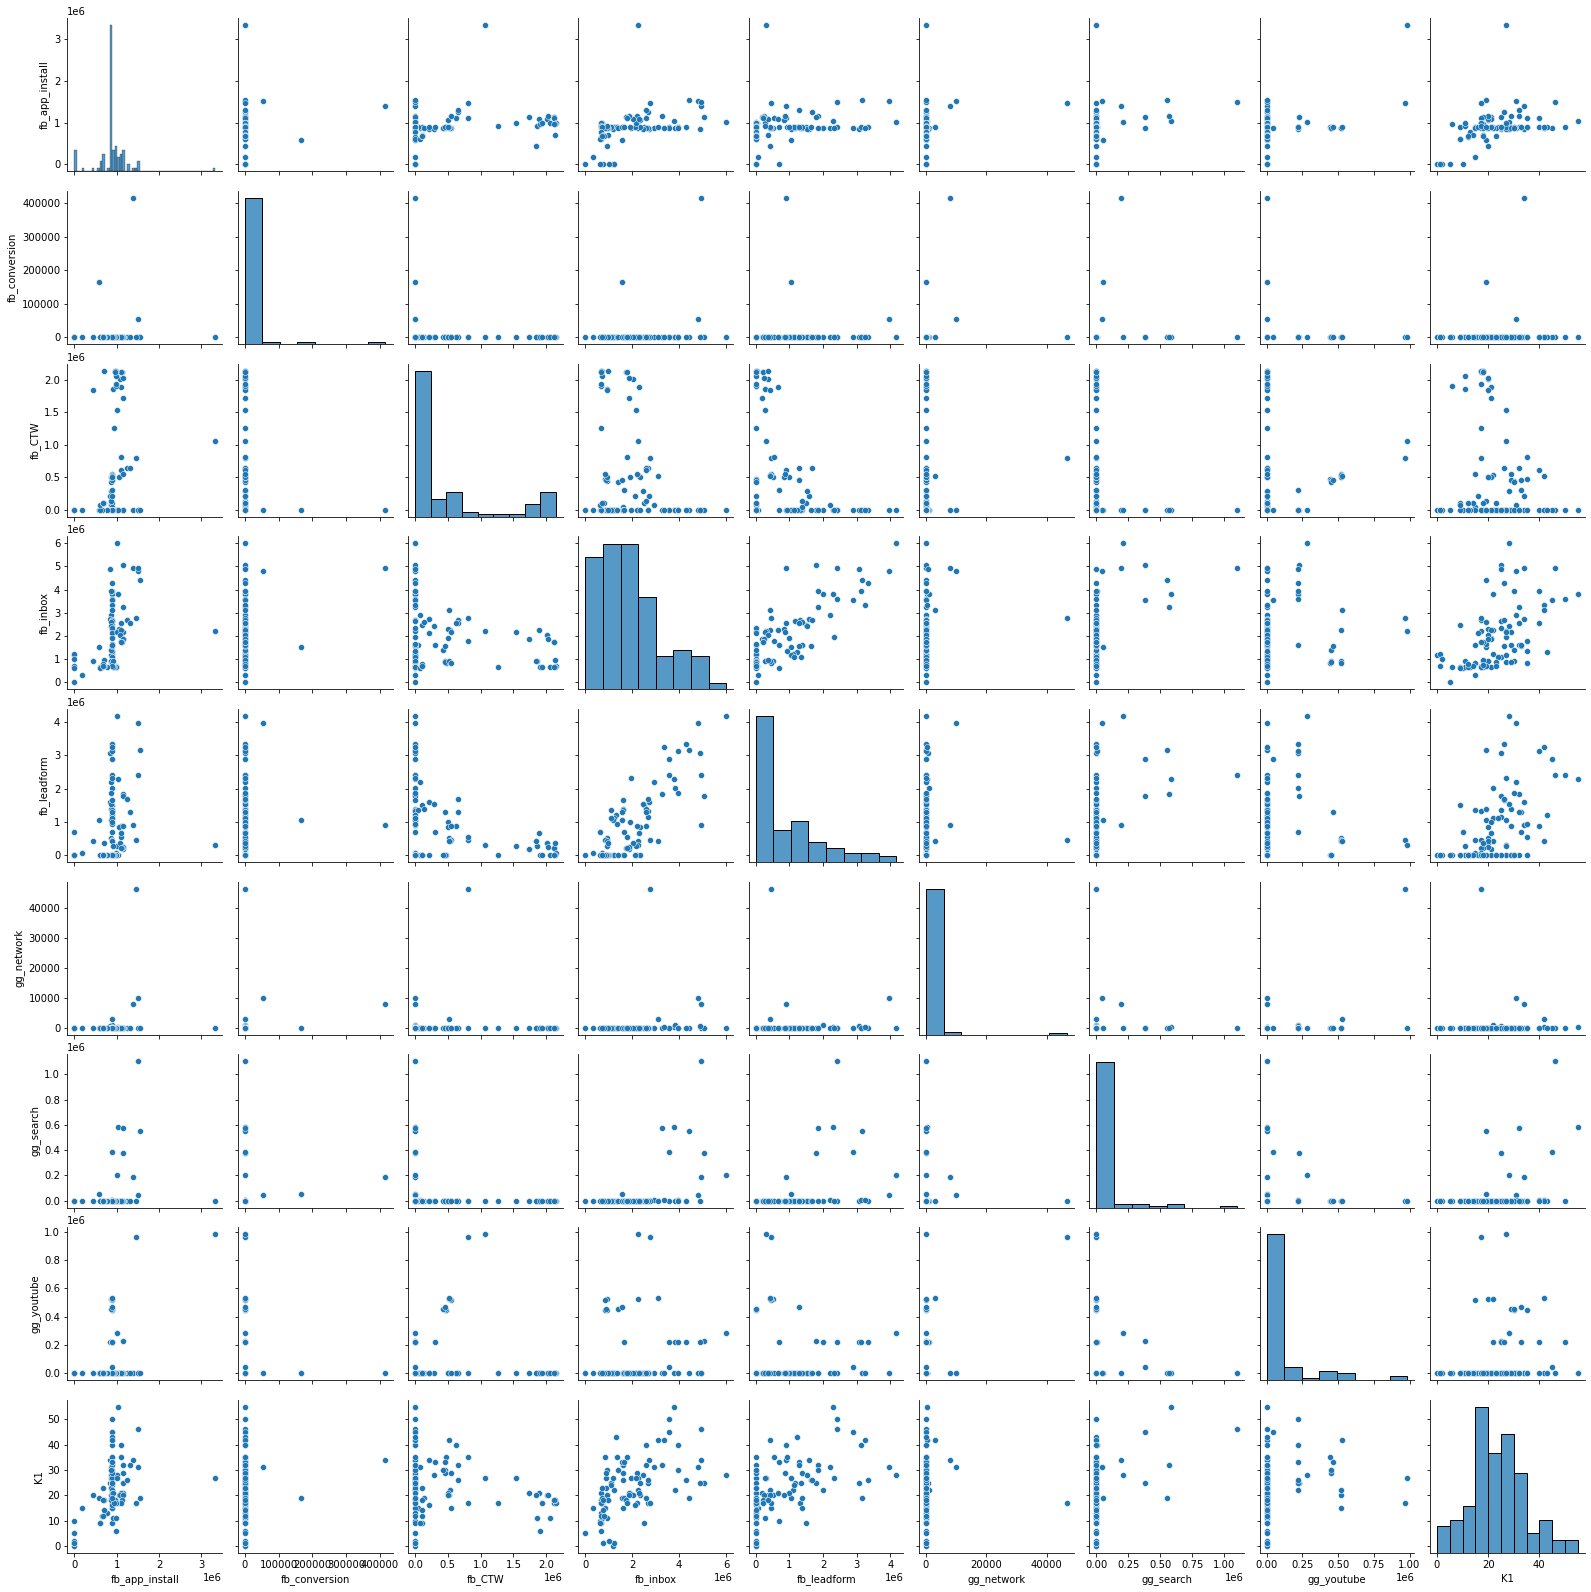

In [46]:
plt.figure(figsize=(50,50))
sns.pairplot(team1[fb_cols+gg_cols+['K1']], vars=fb_cols+gg_cols+['K1'])

In [47]:
# 1.1 Adstock
def apply_adstock(x, L, P, D):
    '''
    params:
    x: original media variable, array
    L: length
    P: peak, delay in effect
    D: decay, retain rate
    returns:
    array, adstocked media variable
    '''
    x = np.append(np.zeros(L-1), x)
    
    weights = np.zeros(L)
    for l in range(L):
        weight = D**((l-P)**2)
        weights[L-1-l] = weight
    
    adstocked_x = []
    for i in range(L-1, len(x)):
        x_array = x[i-L+1:i+1]
        xi = sum(x_array * weights)/sum(weights)
        adstocked_x.append(xi)
    adstocked_x = np.array(adstocked_x)
    return adstocked_x

def adstock_transform(df, Ads_col, adstock_params):
    '''
    params:
    df: original data
    md_cols: list, media variables to be transformed
    adstock_params: dict, 
        e.g., {'sem': {'L': 8, 'P': 0, 'D': 0.1}, 'dm': {'L': 4, 'P': 1, 'D': 0.7}}
    returns: 
    adstocked df
    '''
    Ads_df = pd.DataFrame()
    for Ads_col in Ads_col:
        L, P, D = adstock_params[Ads_col]['L'], adstock_params[Ads_col]['P'], adstock_params[Ads_col]['D']
        Ads_adstock = apply_adstock(df[Ads_col].values, L, P, D)
        Ads_df[Ads_col] = Ads_adstock
    return Ads_df

# 1.2 Diminishing Return
def hill_transform(x, ec, slope):
    return 1 / (1 + (x / ec)**(-slope))

In [48]:
# 2 Create functions
# 2.1 MAPE to evaluate model
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 2.2 To scale data
def apply_mean_center(x):
    mu = np.mean(x)
    xm = x/mu
    return xm, mu

def mean_center_trandform(df, cols):
    '''
    returns: 
    mean-centered df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    return df_new, sc

def mean_log1p_trandform(df, cols):
    '''
    returns: 
    mean-centered, log1p transformed df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        xm, mu = apply_mean_center(x)
        sc[col] = mu
        df_new[col] = np.log1p(xm)
    return df_new, sc

In [98]:
# Create model for control variables
df_ctrl, sc_ctrl = mean_center_trandform(team1, ['K1'])
df_ctrl = pd.concat([df_ctrl, team1[hld_col]], axis = 1)
#df_ctrl = team1[['K1']+hld_col]
# data
ctrl_data = {
    'N': len(df_ctrl),
#     'K1': len(mac_col),
#     'K2': len(hld_col),
    'X1': df_ctrl['hld_holiday'].values,
    'X2': df_ctrl['hld_wkn'].values,
    'y': df_ctrl['K1'].values,
    'max_intercept': min(df_ctrl['K1'])
}

# model code
ctrl_code = '''
data {
  int N; // number of observations
  //int K1; //number of positive predictors
  //int K2; //number of negative predictors
  real max_intercept; // restrict the intercept to be less than the minimum y
  vector[N] X1;
  vector[N] X2;
  vector[N] y; 
}

parameters {
  real beta1; // regression coefficients for X1
  real beta2; // regression coefficients for X2
  real<lower=0, upper=max_intercept> alpha; // intercept
  real<lower=0> noise_var; // residual variance
}

model {
  // Define the priors
  beta1 ~ normal(0, 1); 
  beta2 ~ normal(0, 1); 
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  // The likelihood
  y ~ normal(X1*beta1 + X2*beta2 + alpha, sqrt(noise_var));
}
'''

sm1 = pystan.StanModel(model_code=ctrl_code, verbose=True)
fit1 = sm1.sampling(data=ctrl_data, iter=2000, chains=4)
fit1_result = fit1.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2f4ea39a011c0bb6844cb18fdee40c3 NOW.
INFO:pystan:OS: win32, Python: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)], Cython 0.29.21


Compiling C:\Users\maidn\AppData\Local\Temp\pystan_sx641zxd\stanfit4anon_model_d2f4ea39a011c0bb6844cb18fdee40c3_8578255509020117953.pyx because it changed.
[1/1] Cythonizing C:\Users\maidn\AppData\Local\Temp\pystan_sx641zxd\stanfit4anon_model_d2f4ea39a011c0bb6844cb18fdee40c3_8578255509020117953.pyx
building 'stanfit4anon_model_d2f4ea39a011c0bb6844cb18fdee40c3_8578255509020117953' extension
C:\Users\maidn\Anaconda3\Library\mingw-w64\bin\gcc.exe -mdll -O -Wall -DMS_WIN64 -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -IC:\Users\maidn\AppData\Local\Temp\pystan_sx641zxd -IC:\Users\maidn\Anaconda3\lib\site-packages\pystan -IC:\Users\maidn\Anaconda3\lib\site-packages\pystan\stan\src -IC:\Users\maidn\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math -IC:\Users\maidn\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\eigen_3.3.3 -IC:\Users\maidn\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\boost_1.69.0 -IC:\Users\maidn\Anaconda3\lib\site-packages\

In [99]:
print(fit1.stansummary())

Inference for Stan model: anon_model_d2f4ea39a011c0bb6844cb18fdee40c3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1       0.57  7.1e-3   0.42  -0.24   0.29   0.58   0.85   1.39   3440    1.0
beta2       0.72  3.6e-3   0.22   0.27   0.56   0.72   0.87   1.15   3895    1.0
alpha       0.05  2.5e-4   0.01   0.01   0.05   0.06   0.07   0.07   3589    1.0
noise_var   1.19  3.2e-3   0.19   0.88   1.06   1.17    1.3    1.6   3499    1.0
lp__      -57.62    0.04   1.55 -61.44  -58.4  -57.3 -56.49 -55.69   1725    1.0

Samples were drawn using NUTS at Tue Apr  6 16:14:18 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [102]:
# extract control model parameters and predict base impact -> team1['base_impact']

def extract_ctrl_model(fit_result, extract_param_list=False):
    ctrl_model = {}
#     ctrl_model['hld_col'] = hld_col
#     ctrl_model['mac_col'] = mac_col
    ctrl_model['beta1'] = fit_result['beta1'].mean(axis=0).tolist()
    ctrl_model['beta2'] = fit_result['beta2'].mean(axis=0).tolist()
    ctrl_model['alpha'] = fit_result['alpha'].mean()
    if extract_param_list:
        ctrl_model['beta1_list'] = fit_result['beta1'].tolist()
        ctrl_model['beta2_list'] = fit_result['beta2'].tolist()
        ctrl_model['alpha_list'] = fit_result['alpha'].tolist()
    return ctrl_model

def ctrl_model_predict(ctrl_model, df):
    # hld_col, mac_col = ctrl_model['hld_col'], ctrl_model['mac_col']
    X1, X2 = df['hld_holiday'], df['hld_wkn']
    beta1, beta2 = np.array(ctrl_model['beta1']), np.array(ctrl_model['beta2'])
    alpha = ctrl_model['alpha']
    y_pred = np.dot(X1,beta1) + np.dot(X2,beta2) + alpha
    return y_pred

base_sales_model = extract_ctrl_model(fit1_result)
base_impact = ctrl_model_predict(base_sales_model, df_ctrl)
team1['base_impact'] = base_impact*np.mean(team1['K1'])
# evaluate control model
print('mape: ', mean_absolute_percentage_error(team1['K1'], team1['base_impact']))

mape:  97.18093360169773


In [101]:
# 2.2 Marketing Mix Model
df_mmm, sc_mmm = mean_log1p_trandform(team1, ['K1', 'base_impact'])
mu_ads = team1[ads_cols].apply(np.mean, axis=0).values
max_lag = 7
num_ads = len(ads_cols)
# padding zero * (max_lag-1) rows
X_ads = np.concatenate((np.zeros((max_lag-1, num_ads)), team1[ads_cols].values), axis=0)
X_ctrl = df_mmm['base_impact'].values.reshape(len(team1),1)
model_data2 = {
    'N': len(team1),
    'max_lag': max_lag, 
    'num_ads': num_ads,
    'X_ads': X_ads, 
    'mu_ads': mu_ads,
    'num_ctrl': X_ctrl.shape[1],
    'X_ctrl': X_ctrl, 
    'y': df_mmm['K1'].values
}

model_code2 = '''
functions {
  // the adstock transformation with a vector of weights
  real Adstock(vector t, row_vector weights) {
    return dot_product(t, weights) / sum(weights);
  }
}
data {
  // the total number of observations
  int<lower=1> N;
  // the vector of sales
  real y[N];
  // the maximum duration of lag effect, in weeks
  int<lower=1> max_lag;
  // the number of ads channels
  int<lower=1> num_ads;
  // matrix of ads variables
  matrix[N+max_lag-1, num_ads] X_ads;
  // vector of ads variables' mean
  real mu_ads[num_ads];
  // the number of other control variables
  int<lower=1> num_ctrl;
  // a matrix of control variables
  matrix[N, num_ctrl] X_ctrl;
}
parameters {
  // residual variance
  real<lower=0> noise_var;
  // the intercept
  real tau;
  // the coefficients for ads variables and base sales
  vector<lower=0>[num_ads+num_ctrl] beta;
  // the decay and peak parameter for the adstock transformation of
  // each ads
  vector<lower=0,upper=1>[num_ads] decay;
  vector<lower=0,upper=ceil(max_lag/2)>[num_ads] peak;
}
transformed parameters {
  // the cumulative media effect after adstock
  real cum_effect;
  // matrix of ads variables after adstock
  matrix[N, num_ads] X_ads_adstocked;
  // matrix of all predictors
  matrix[N, num_ads+num_ctrl] X;
  
  // adstock, mean-center, log1p transformation
  row_vector[max_lag] lag_weights;
  for (nn in 1:N) {
    for (ads in 1 : num_ads) {
      for (lag in 1 : max_lag) {
        lag_weights[max_lag-lag+1] <- pow(decay[ads], (lag - 1 - peak[ads]) ^ 2);
      }
     cum_effect <- Adstock(sub_col(X_ads, nn, ads, max_lag), lag_weights);
     X_ads_adstocked[nn, ads] <- log1p(cum_effect/mu_ads[ads]);
    }
  X <- append_col(X_ads_adstocked, X_ctrl);
  } 
}
model {
  decay ~ beta(3,3);
  peak ~ uniform(0, ceil(max_lag/2));
  tau ~ normal(0, 5);
  for (i in 1 : num_ads+num_ctrl) {
    beta[i] ~ normal(0, 1);
  }
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  y ~ normal(tau + X * beta, sqrt(noise_var));
}
'''

sm2 = pystan.StanModel(model_code=model_code2, verbose=True)
fit2 = sm2.sampling(data=model_data2, iter=1000, chains=3)
fit2_result = fit2.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_58cff730d19d5b299e5dd13fea794504 NOW.
INFO:pystan:OS: win32, Python: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)], Cython 0.29.21


Compiling C:\Users\maidn\AppData\Local\Temp\pystan_j3zvgumb\stanfit4anon_model_58cff730d19d5b299e5dd13fea794504_8489528109944324648.pyx because it changed.
[1/1] Cythonizing C:\Users\maidn\AppData\Local\Temp\pystan_j3zvgumb\stanfit4anon_model_58cff730d19d5b299e5dd13fea794504_8489528109944324648.pyx
building 'stanfit4anon_model_58cff730d19d5b299e5dd13fea794504_8489528109944324648' extension
C:\Users\maidn\Anaconda3\Library\mingw-w64\bin\gcc.exe -mdll -O -Wall -DMS_WIN64 -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -IC:\Users\maidn\AppData\Local\Temp\pystan_j3zvgumb -IC:\Users\maidn\Anaconda3\lib\site-packages\pystan -IC:\Users\maidn\Anaconda3\lib\site-packages\pystan\stan\src -IC:\Users\maidn\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math -IC:\Users\maidn\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\eigen_3.3.3 -IC:\Users\maidn\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\boost_1.69.0 -IC:\Users\maidn\Anaconda3\lib\site-packages\

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


C:\Users\maidn\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\maidn\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\maidn\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

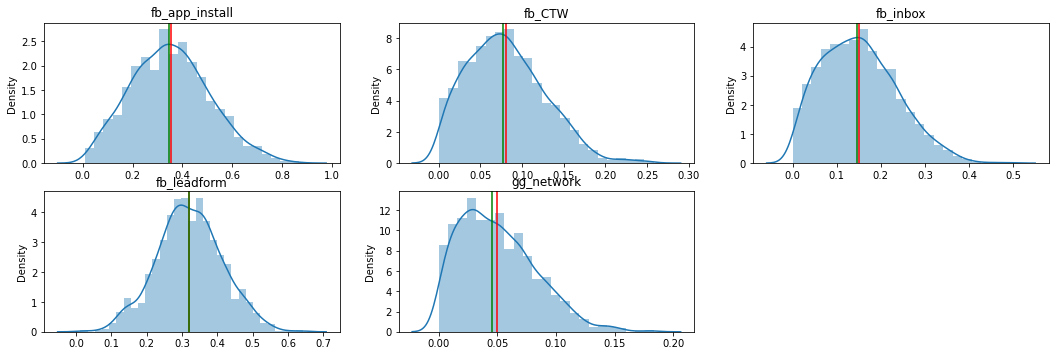

In [103]:
# extract mmm parameters
def extract_mmm(fit_result, max_lag=max_lag, 
                ads_vars=ads_cols, ctrl_vars=['base_impact'], 
                extract_param_list=True):
    mmm = {}
    
    mmm['max_lag'] = max_lag
    mmm['ads_vars'], mmm['ctrl_vars'] = ads_vars, ctrl_vars
    mmm['decay'] = decay = fit_result['decay'].mean(axis=0).tolist()
    mmm['peak'] = peak = fit_result['peak'].mean(axis=0).tolist()
    mmm['beta'] = fit_result['beta'].mean(axis=0).tolist()
    mmm['tau'] = fit_result['tau'].mean()
    if extract_param_list:
        mmm['decay_list'] = fit_result['decay'].tolist()
        mmm['peak_list'] = fit_result['peak'].tolist()
        mmm['beta_list'] = fit_result['beta'].tolist()
        mmm['tau_list'] = fit_result['tau'].tolist()
    
    adstock_params = {}
    ads_names = [col.replace('ads_', '') for col in ads_vars]
    for i in range(len(ads_names)):
        adstock_params[ads_names[i]] = {
            'L': max_lag,
            'P': peak[i],
            'D': decay[i]
        }
    mmm['adstock_params'] = adstock_params
    return mmm

mmm = extract_mmm(fit2, max_lag=max_lag, 
                ads_vars=ads_cols, ctrl_vars=['base_impact'])


# plot ads coefficients' distributions
# red line: mean, green line: median
beta_ads = {}
for i in range(len(mmm['ads_vars'])):
    md = mmm['ads_vars'][i]
    betas = []
    for j in range(len(mmm['beta_list'])):
        betas.append(mmm['beta_list'][j][i])
    beta_ads[md] = np.array(betas)

f = plt.figure(figsize=(18,15))
for i in range(len(mmm['ads_vars'])):
    ax = f.add_subplot(5,3,i+1)
    md = mmm['ads_vars'][i]
    x = beta_ads[md]
    mean_x = x.mean()
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-')
    ax.axvline(median_x, color='g', linestyle='-')
    ax.set_title(md)

In [33]:
mmm

{'max_lag': 8,
 'ads_vars': ['fb_app_install',
  'fb_CTW',
  'fb_inbox',
  'fb_leadform',
  'gg_network',
  'gg_search',
  'gg_youtube'],
 'ctrl_vars': ['base_impact'],
 'decay': [0.43317453463319666,
  0.5033028233857421,
  0.453664838311397,
  0.47874836605548593,
  0.4988911357867602,
  0.5172836349961112,
  0.4485315674751005],
 'peak': [0.3996587132044034,
  1.9651560049087715,
  0.5597892496056529,
  1.0765495289913718,
  2.0281567087090973,
  1.294387976523345,
  0.5335217325876972],
 'beta': [0.33476362814835386,
  0.03334227511766989,
  0.18430340691479913,
  0.049405373852645824,
  0.021787282689506082,
  0.09698728859376313,
  0.1258866201526192,
  0.05269690027232882],
 'tau': 0.13548170741349488,
 'decay_list': [[0.45356517175671085,
   0.49743012291310695,
   0.4228049849502673,
   0.7131177335566871,
   0.4740105044675521,
   0.6814709767137922,
   0.21488377091320054],
  [0.19232589970396674,
   0.9074229378682933,
   0.7830446588942173,
   0.319598394711337,
   0.48412

In [ ]:
mmm['ads_vars']

In [ ]:
mmm['ctrl_vars']

In [104]:
# Decompose sales to ads channels' contribution
# Each ads's contribution = total Impact - Impact upon removal the Ads    

# đưa các biến từ mô hình mmm vào data và scale
def mmm_decompose_contrib(mmm, team1, original_impact=team1['K1']):
    # adstock params từ mô hình mmm
    adstock_params = mmm['adstock_params']
    # coefficients, intercept lấy từ mô hình mmm
    beta, tau = mmm['beta'], mmm['tau']
    # variables từ mô hình mmm
    ads_vars, ctrl_vars = mmm['ads_vars'], mmm['ctrl_vars']
    num_ads, num_ctrl = len(ads_vars), len(ctrl_vars)
    # X_ads: adstocked, mean-centered ads variables + 1
    X_ads2 = adstock_transform(team1, ads_vars, adstock_params)
    X_ads2, sc_mmm2 = mean_center_trandform(X_ads2, ads_vars)
    X_ads2 = X_ads2 + 1
    # X_ctrl2, mean-centered control variables + 1
    X_ctrl2, sc_mmm2_1 = mean_center_trandform(team1[ctrl_vars], ctrl_vars)
    X_ctrl2 = X_ctrl2 + 1
    # y_true2, mean-centered sales variable + 1
    y_true2, sc_mmm2_2 = mean_center_trandform(team1, ['K1'])
    y_true2 = y_true2 + 1
    sc_mmm2.update(sc_mmm2_1)
    sc_mmm2.update(sc_mmm2_2)
    # X2 <- ads variables + ctrl variable
    X2 = pd.concat([X_ads2, X_ctrl2], axis=1)

    # 1. compute each ads/control factor: 
    # log-log model: log(impact) = log(X[0])*beta[0] + ... + log(X[13])*beta[13] + tau
    # multiplicative model: impact = X[0]^beta[0] * ... * X[13]^beta[13] * e^tau
    # each factor = X[i]^beta[i]
    # intercept = e^tau
    factor_df = pd.DataFrame(columns=ads_vars+ctrl_vars+['intercept'])
    for i in range(num_ads):
        colname = ads_vars[i]
        factor_df[colname] = X2[colname] ** beta[i]
    for i in range(num_ctrl):
        colname = ctrl_vars[i]
        factor_df[colname] = X2[colname] ** beta[num_ads+i]
    factor_df['intercept'] = np.exp(tau)

    # 2. dự đoán impact y_pred với các biến đưa vào từ mô hình mmm
    # baseline = intercept * control factor = e^tau * X[13]^beta[13]
    y_pred = factor_df.apply(np.prod, axis=1)
    factor_df['y_pred'], factor_df['y_true2'] = y_pred, y_true2
    factor_df['baseline'] = factor_df[['intercept']+ctrl_vars].apply(np.prod, axis=1)

    # 3. tính tỷ lệ phân phối giữa các kênh ads
    # ads contribution = total volume – volume upon removal of the ads factor
    mc_df = pd.DataFrame(columns=ads_vars+['baseline'])
    for col in ads_vars:
        mc_df[col] = factor_df['y_true2'] - factor_df['y_true2']/factor_df[col]
    mc_df['baseline'] = factor_df['baseline']
    mc_df['y_true2'] = factor_df['y_true2']

    # 4. scale contribution
    # predicted total ads contribution: product of all media factors
    mc_df['mc_pred'] = mc_df[ads_vars].apply(np.sum, axis=1)
    # true total media contribution: total volume - baseline
    mc_df['mc_true'] = mc_df['y_true2'] - mc_df['baseline']
    # predicted total media contribution is slightly different from true total media contribution
    # scale each media factor’s contribution by removing the delta volume proportionally
    mc_df['mc_delta'] =  mc_df['mc_pred'] - mc_df['mc_true']
    for col in ads_vars:
        mc_df[col] = mc_df[col] - mc_df['mc_delta']*mc_df[col]/mc_df['mc_pred']

    # 5. scale mc_df based on original impact
    mc_df['K1'] = original_impact
    for col in ads_vars+['baseline']:
        mc_df[col] = mc_df[col]*mc_df['K1']/mc_df['y_true2']
    
    print('rmse (log-log model): ', 
         mean_squared_error(np.log(y_true2), np.log(y_pred)) ** (1/2))
    print('mape (multiplicative model): ', 
         mean_absolute_percentage_error(y_true2, y_pred))
    return mc_df

# calculate ads contribution percentage
def calc_ads_contrib_pct(mc_df, ads_vars=ads_cols, impact_col='K1', period=52):
    '''
    returns:
    mc_pct: percentage over total sales
    mc_pct2: percentage over incremental sales (sales contributed by media channels)
    '''
    mc_pct = {}
    mc_pct2 = {}
    s = 0
    if period is None:
        for col in (ads_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[impact_col]).mean()
    else:
        for col in (ads_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[impact_col])[-period:].mean()
    for m in ads_vars:
        s += mc_pct[m]
    for m in ads_vars:
        mc_pct2[m] = mc_pct[m]/s
    return mc_pct, mc_pct2

mc_df = mmm_decompose_contrib(mmm, team1, original_impact=team1['K1'])
adstock_params = mmm['adstock_params']
mc_pct, mc_pct2 = calc_ads_contrib_pct(mc_df, period=52)
# mc_df.to_csv('mc_df1.csv', index=False)
# save_json(adstock_params, 'adstock_params1.json')
# pd.concat([
#     pd.DataFrame.from_dict(mc_pct, orient='index', columns=['mc_pct']),
#     pd.DataFrame.from_dict(mc_pct2, orient='index', columns=['mc_pct2'])
# ], axis=1).to_csv('mc_pct_df1.csv')

rmse (log-log model):  0.25013449863670945
mape (multiplicative model):  23.845561176407127


In [105]:
mc_pct2

{'fb_app_install': 0.43777394682928145,
 'fb_CTW': 0.10064835528375417,
 'fb_inbox': 0.15894420351688038,
 'fb_leadform': 0.2783502052412487,
 'gg_network': 0.024283289128835324}

In [106]:
adstock_params

{'fb_app_install': {'L': 7, 'P': 0.7391684828399135, 'D': 0.4638045675713165},
 'fb_CTW': {'L': 7, 'P': 1.4947660577075188, 'D': 0.5101492101627871},
 'fb_inbox': {'L': 7, 'P': 1.140701033534015, 'D': 0.5090407233461142},
 'fb_leadform': {'L': 7, 'P': 0.9290159823863863, 'D': 0.49855163632404076},
 'gg_network': {'L': 7, 'P': 1.4622058057987615, 'D': 0.5040443283237}}

Text(0.5, 1.0, 'Adstock Parameter: Decay')

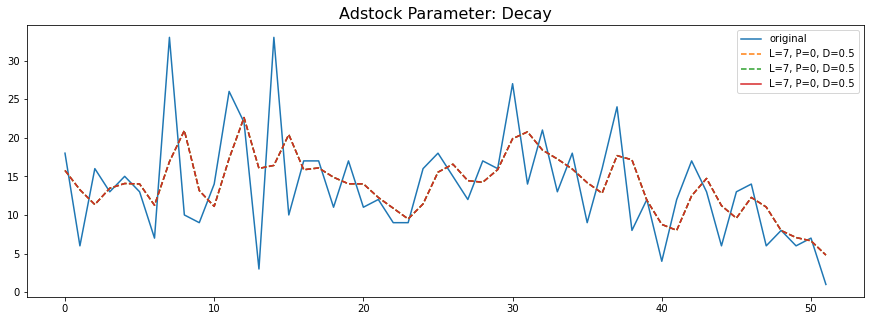

In [112]:
 fig, ax = plt.subplots(figsize=(15,5))
psets = adstock_params['fb_app_install']
xm = team1['K1'].values
sns.lineplot(x=range(52), y=xm[-52:], ax=ax, label='original')
for i in range(len(psets)):
    L, P, D = psets['L'], psets['P'], psets['D']
    xm_adstocked = apply_adstock(xm, L, P, D)
    sns.lineplot(x=range(52), y=xm_adstocked[-52:], ax=ax, 
                 label='L=%d, P=%d, D=%.1f'%(L, P, D))
    ax.lines[i+1].set_linestyle("--")
ax.set_title('Adstock Parameter: Decay', fontsize=16)